In [2]:
from datasets import load_dataset

ds = load_dataset("PatronusAI/financebench")

In [3]:
len(ds["train"])

150

In [4]:
for key in ds["train"][0].keys():
    print(key)

financebench_id
company
doc_name
question_type
question_reasoning
domain_question_num
question
answer
justification
dataset_subset_label
evidence
gics_sector
doc_type
doc_period
doc_link


In [5]:
ds["train"][0]["doc_link"]

'https://investors.3m.com/financials/sec-filings/content/0001558370-19-000470/0001558370-19-000470.pdf'

In [6]:
ds["train"][0]["doc_name"]

'3M_2018_10K'

In [9]:
ds["train"][0]["evidence"]

[{'evidence_text': 'Table of Contents \n3M Company and Subsidiaries\nConsolidated Statement of Cash Flow s\nYears ended December 31\n \n(Millions)\n \n2018\n \n2017\n \n2016\n \nCash Flows from Operating Activities\n \n \n \n \n \n \n \nNet income including noncontrolling interest\n \n$\n5,363 \n$\n4,869 \n$\n5,058 \nAdjustments to reconcile net income including noncontrolling interest to net cash\nprovided by operating activities\n \n \n \n \n \n \n \nDepreciation and amortization\n \n \n1,488 \n \n1,544 \n \n1,474 \nCompany pension and postretirement contributions\n \n \n(370) \n \n(967) \n \n(383) \nCompany pension and postretirement expense\n \n \n410 \n \n334 \n \n250 \nStock-based compensation expense\n \n \n302 \n \n324 \n \n298 \nGain on sale of businesses\n \n \n(545) \n \n(586) \n \n(111) \nDeferred income taxes\n \n \n(57) \n \n107 \n \n 7 \nChanges in assets and liabilities\n \n \n \n \n \n \n \nAccounts receivable\n \n \n(305) \n \n(245) \n \n(313) \nInventories\n \n \n(50

In [10]:
for i in range (10):
    print(ds["train"][i]["evidence"][0]["evidence_page_num"])

59
57
47
26
24
4
0
61
68
69


In [11]:
import fitz
from pathlib import Path
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import io
from base64 import b64encode
import csv

DPI = 300
FORMAT = "png"

def process_single_pdf(args):
    """Process a single PDF file and return base64 encoded images"""
    pdf_file, dpi, fmt = args
    
    zoom = dpi / 72.0
    mat = fitz.Matrix(zoom, zoom)
    
    start = time.time()
    try:
        doc = fitz.open(pdf_file)
    except Exception as e:
        return {"success": False, "filename": pdf_file.name, "error": str(e)}
    
    filename = pdf_file.stem
    pages_data = []
    
    for i, page in enumerate(doc, start=1):
        pix = page.get_pixmap(matrix=mat, alpha=False)
        
        # Convert to base64
        buf = io.BytesIO()
        img_bytes = pix.pil_tobytes(format=fmt.upper())
        buf.write(img_bytes)
        byte_data = buf.getvalue()
        base64_str = b64encode(byte_data).decode("utf-8")
        
        pages_data.append({
            "page_number": i,
            "base64": base64_str
        })
    
    doc.close()
    elapsed = time.time() - start
    
    return {
        "success": True,
        "filename": pdf_file.name,
        "pdf_stem": filename,
        "pages": pages_data,
        "num_pages": len(pages_data),
        "time": elapsed
    }

def process_pdfs_to_base64(
    pdf_folder="financebench-pdfs",
    dpi=DPI,
    fmt=FORMAT,
    max_workers=4
):
    pdf_path = Path(pdf_folder)
    
    pdf_files = list(pdf_path.glob("*.pdf"))
    
    if not pdf_files:
        print("No PDF files found.")
        return []
    
    print(f"Processing {len(pdf_files)} PDFs using {max_workers} workers...")
    
    failed_to_open = []
    all_results = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_single_pdf, (pdf_file, dpi, fmt)): pdf_file
            for pdf_file in pdf_files
        }
        
        for future in as_completed(futures):
            result = future.result()
            if result["success"]:
                print(f"Processed {result['num_pages']} pages from {result['filename']} in {result['time']:.2f} seconds.")
                all_results.append(result)
            else:
                print(f"Could not open {result['filename']}: {result['error']}")
                failed_to_open.append(result['filename'])
    
    if failed_to_open:
        print("\nFailed to open the following PDF files:")
        for fname in failed_to_open:
            print(fname)
    
    print(f"\nSuccessfully processed {len(all_results)} PDF(s).")
    return all_results

def save_results_to_csv(results, output_file="pdf_base64_encodings.csv"):
    """Save the base64 encodings to a CSV file"""
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['pdf_filename', 'pdf_stem', 'page_number', 'base64_encoding']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        
        for pdf_result in results:
            for page in pdf_result['pages']:
                writer.writerow({
                    'pdf_filename': pdf_result['filename'],
                    'pdf_stem': pdf_result['pdf_stem'],
                    'page_number': page['page_number'],
                    'base64_encoding': page['base64']
                })
    
    print(f"\nSaved base64 encodings to {output_file}")

pdf_processing_start = time.time()
results = process_pdfs_to_base64()
print(f"PDF processing completed in {time.time() - pdf_processing_start:.2f} seconds.")

# Save to CSV
if results:
    save_results_to_csv(results)

Processing 80 PDFs using 4 workers...
Could not open KRAFTHEINZ_2019_10K.pdf: cannot open broken document
Processed 181 pages from AMERICANWATERWORKS_2021_10K.pdf in 24.25 seconds.
Processed 179 pages from JPMORGAN_2021Q1_10Q.pdf in 29.20 seconds.
Processed 195 pages from AMCOR_2020_10K.pdf in 30.00 seconds.
Processed 220 pages from MGMRESORTS_2022_10K.pdf in 33.05 seconds.
Processed 92 pages from 3M_2023Q2_10Q.pdf in 12.89 seconds.
Processed 73 pages from NETFLIX_2017_10K.pdf in 10.69 seconds.
Processed 152 pages from AMERICANWATERWORKS_2020_10K.pdf in 24.67 seconds.
Processed 213 pages from CVSHEALTH_2022_10K.pdf in 34.74 seconds.
Processed 170 pages from WALMART_2020_10K.pdf in 26.41 seconds.
Could not open MGMRESORTS_2022Q4_EARNINGS.pdf: cannot open empty document
Processed 260 pages from AMERICANEXPRESS_2022_10K.pdf in 39.36 seconds.
Processed 183 pages from COCACOLA_2022_10K.pdf in 26.11 seconds.
Processed 75 pages from BESTBUY_2023_10K.pdf in 12.11 seconds.
Processed 121 pages f

In [12]:
import pandas as pd

df = pd.read_csv("financebench_pages_base64.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10955 entries, 0 to 10954
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   pdf_filename     10955 non-null  object
 1   pdf_stem         10955 non-null  object
 2   page_number      10955 non-null  int64 
 3   base64_encoding  10955 non-null  object
dtypes: int64(1), object(3)
memory usage: 342.5+ KB


In [22]:
print(df.iloc[10]["pdf_filename"])
print(df.iloc[10]["page_number"])

AMERICANWATERWORKS_2021_10K.pdf
11


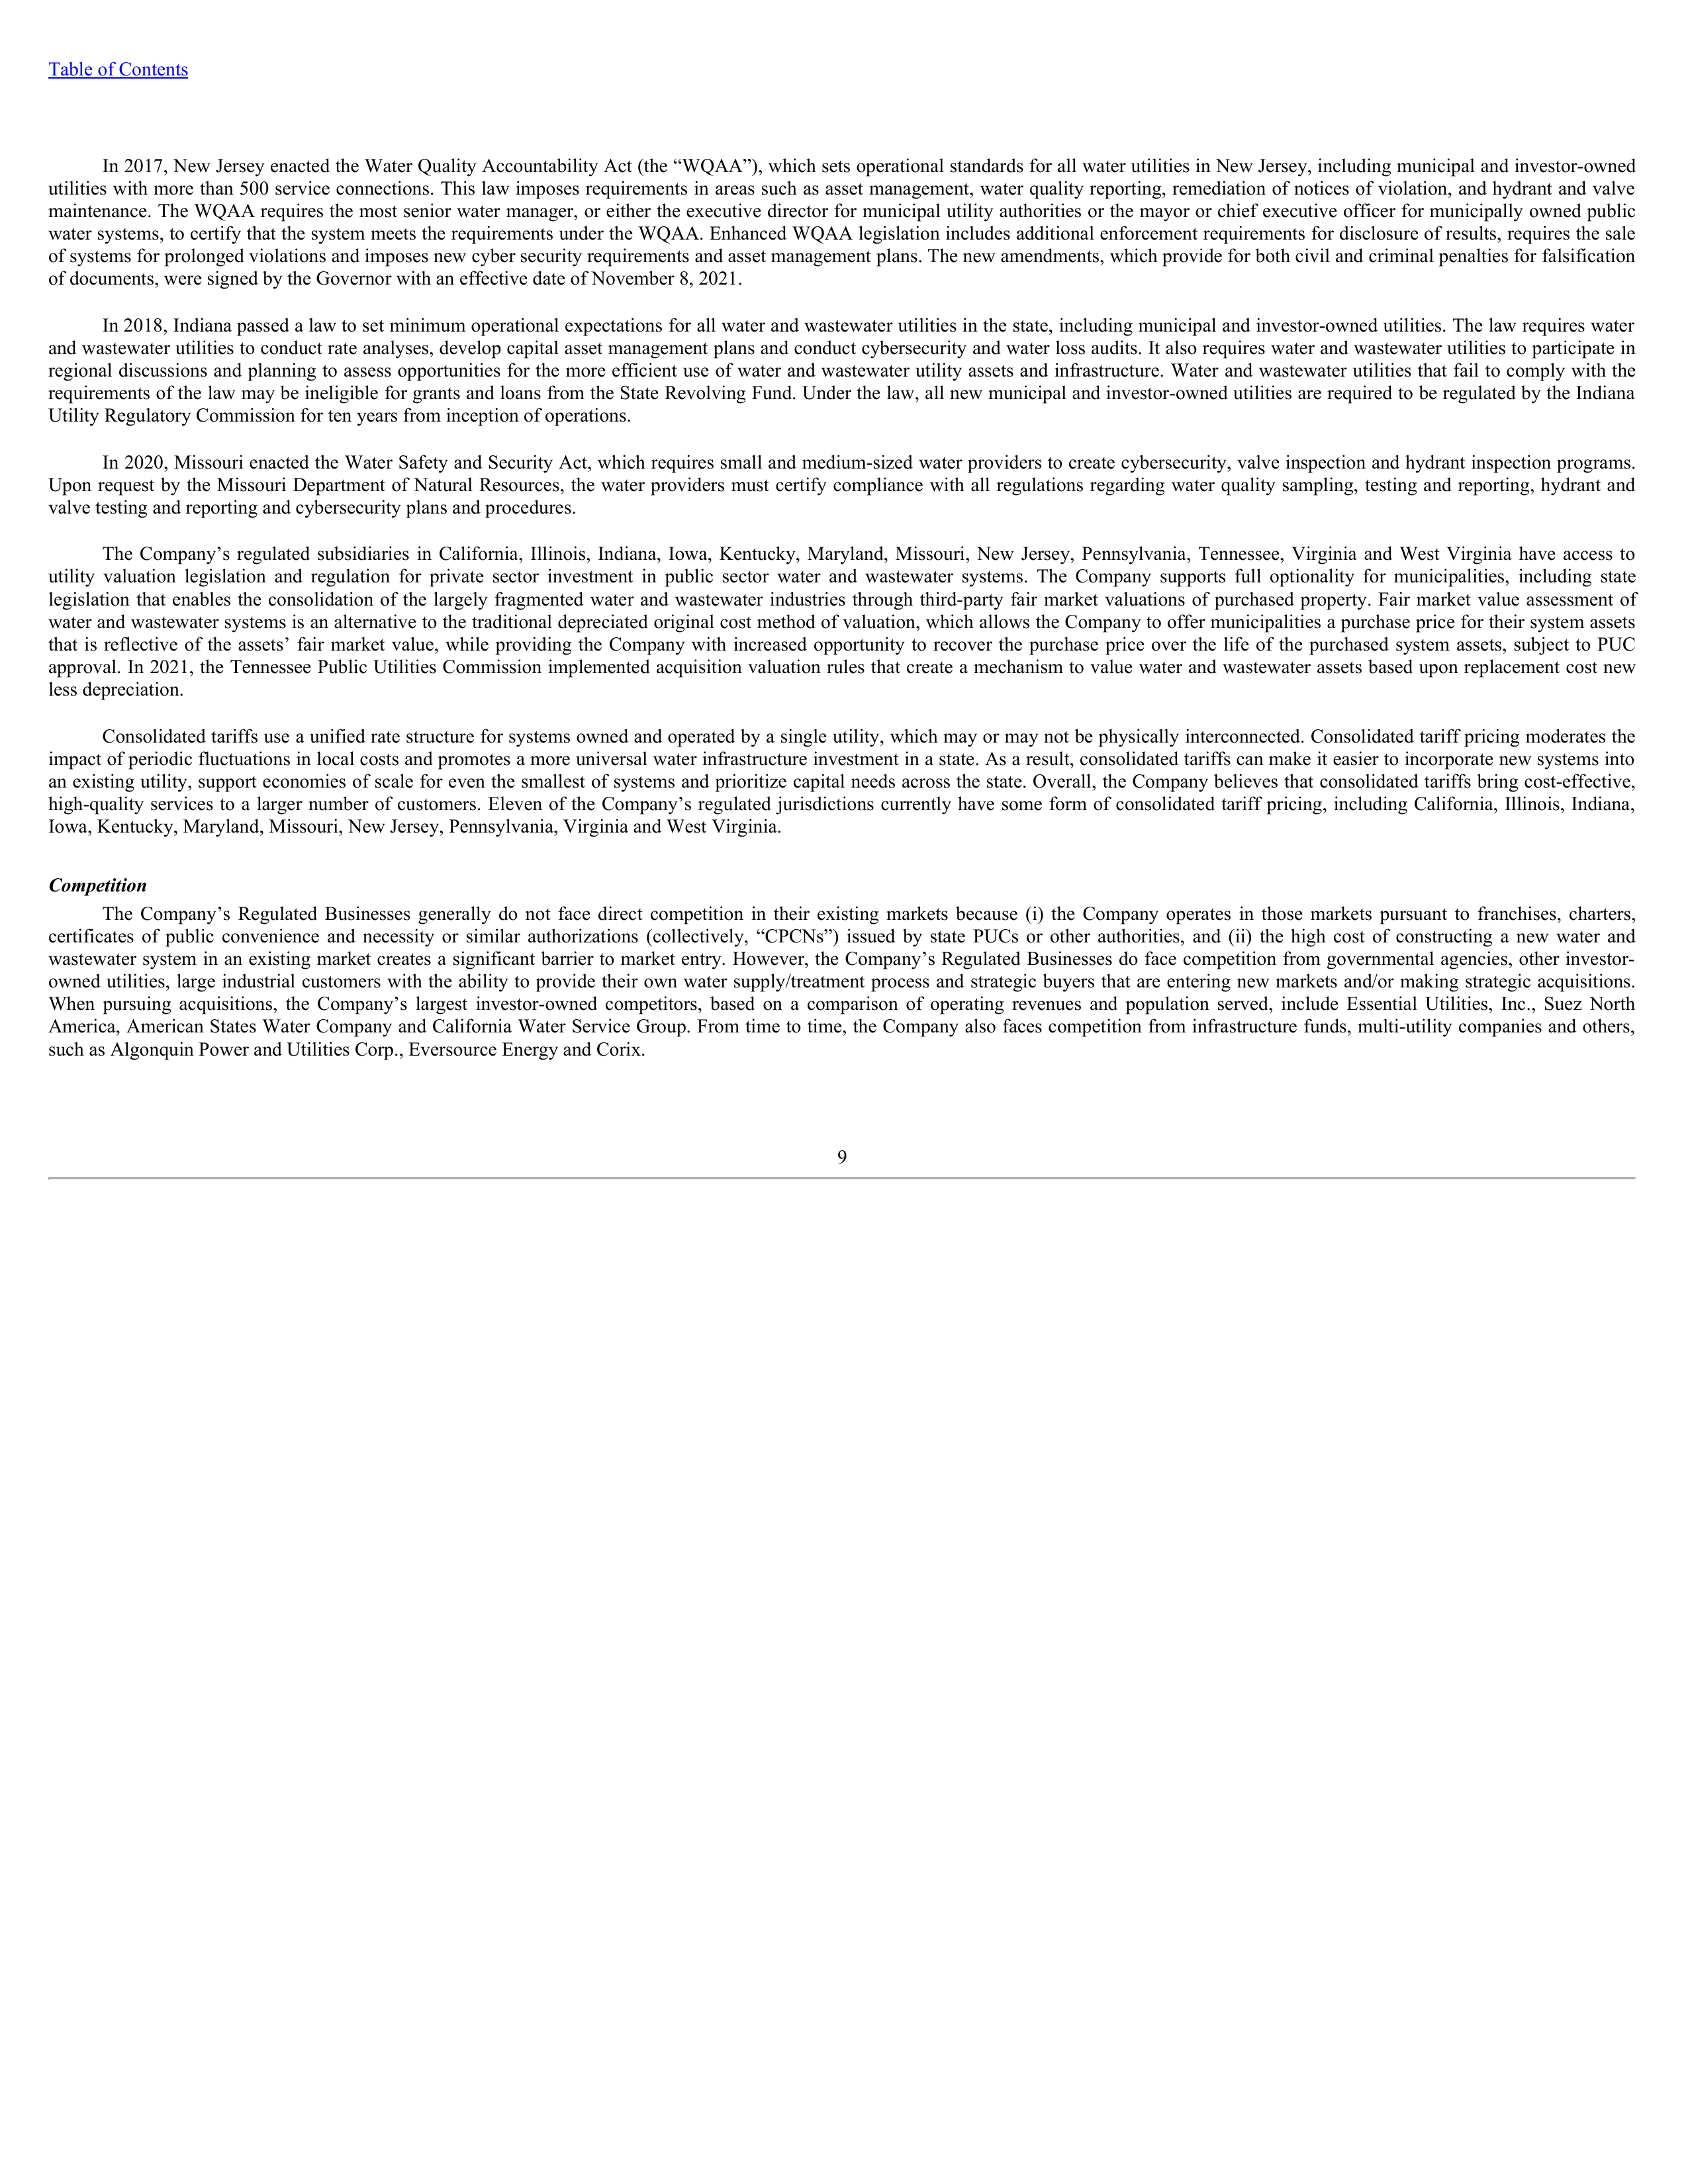

In [23]:
from IPython.display import display, Image
from base64 import b64decode
display(Image(data=b64decode(df.iloc[10]["base64_encoding"])))